<a href="https://colab.research.google.com/github/KumudaBG/CMPE-297-Special-Topics-Assignments/blob/main/Assignment5/avalanche_CL_for_omniglot_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install git+https://github.com/ContinualAI/avalanche.git 

  Cloning https://github.com/ContinualAI/avalanche.git to /tmp/pip-req-build-uee4h9_a
  Running command git clone -q https://github.com/ContinualAI/avalanche.git /tmp/pip-req-build-uee4h9_a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 121 kB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.7 MB 39.9 MB/s 
     |████████████████████████████████| 532 kB 41.8 MB/s 
     |████████████████████████████████| 139 kB 51.8 MB/s 
     |████████████████████████████████| 97 kB 6.9 MB/s 
     |████████████████████████████████| 180 kB 48.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for avalanche-lib: filename=avalanche_lib-0.0.1-py3-none-any.whl size=414160 sha256=ebf48b843fc59fe3f085435a05c3e69179909d443c98cb566e203723f

In [2]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import transforms

In [20]:
from avalanche.benchmarks.classic import SplitOmniglot,PermutedOmniglot
from avalanche.benchmarks.classic.classic_benchmarks_utils import \
    check_vision_benchmark
from torchvision.transforms import ToTensor, ToPILImage, Compose, Normalize,RandomRotation
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, \
    loss_metrics, timing_metrics, cpu_usage_metrics, confusion_matrix_metrics, disk_usage_metrics
from avalanche.models import SimpleMLP
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.strategies import Naive

In [4]:
# Config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [55]:
_default_omniglot_train_transform = Compose([
    transforms.Resize(32),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.9221,), (0.2681,))
])

_default_omniglot_eval_transform = Compose([
    transforms.Resize(32),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.9221,), (0.2681,))
])


Files already downloaded and verified
Files already downloaded and verified
The benchmark instance contains 4 training experiences.
Train experience 0
X tensor: torch.Size([300, 1, 105, 105])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


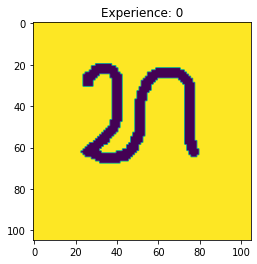

Train experience 1
X tensor: torch.Size([300, 1, 105, 105])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


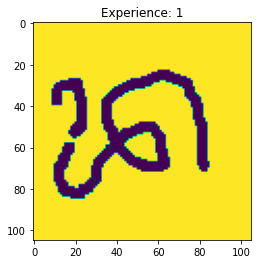

Train experience 2
X tensor: torch.Size([300, 1, 105, 105])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


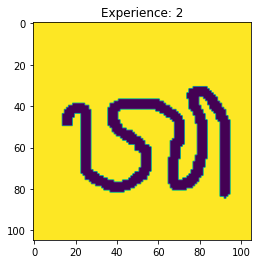

Train experience 3
X tensor: torch.Size([300, 1, 105, 105])
Y tensor: torch.Size([300])
T tensor: torch.Size([300])


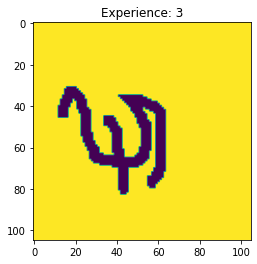

In [66]:
#964
# CL Benchmark Creation
#split_omniglot = SplitOmniglot(n_experiences=4)
scenario = SplitOmniglot(4,train_transform=_default_omniglot_train_transform\
                            ,eval_transform=_default_omniglot_eval_transform)
check_vision_benchmark(scenario)

In [67]:
train_stream=scenario.train_stream
test_stream=scenario.test_stream

In [68]:
# Config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [69]:
print(device)
print(scenario.n_classes)

cuda:0
964


In [70]:
# Prepare for training & testing
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

In [76]:
# MODEL CREATION
model = SimpleMLP(num_classes=scenario.n_classes,input_size=1024)

In [72]:
# DEFINE THE EVALUATION PLUGIN and LOGGERS
# The evaluation plugin manages the metrics computation.
# It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.
# log to Tensorboard
tb_logger = TensorboardLogger()

In [73]:
# log to text file
text_logger = TextLogger(open('log.txt', 'a'))

# print to stdout
interactive_logger = InteractiveLogger()

In [79]:
print(interactive_logger)

In [77]:
from avalanche.training.plugins import EvaluationPlugin
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    forgetting_metrics(experience=True, stream=True),
    cpu_usage_metrics(experience=True),
    confusion_matrix_metrics(num_classes=scenario.n_classes, save_image=False,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger, tb_logger]
)

/usr/local/lib/python3.7/dist-packages/avalanche/training/plugins/evaluation.py:84: UserWarning: No benchmark provided to the evaluation plugin. Metrics may be computed on inconsistent portion of streams, use at your own risk.
  "No benchmark provided to the evaluation plugin. "


In [78]:
# CREATE THE STRATEGY INSTANCE (NAIVE)
cl_strategy = Naive(
    model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=500, train_epochs=1, eval_mb_size=100,
    evaluator=eval_plugin)

# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [2, 3, 516, 7, 519, 12, 18, 540, 31, 544, 545, 36, 38, 39, 41, 553, 44, 46, 561, 50, 51, 52, 567, 569, 58, 570, 62, 63, 578, 67, 68, 581, 582, 584, 73, 585, 78, 591, 82, 595, 84, 87, 601, 91, 603, 604, 96, 610, 611, 102, 105, 106, 618, 108, 622, 114, 626, 628, 629, 119, 631, 632, 127, 643, 645, 646, 137, 144, 656, 658, 660, 661, 151, 153, 154, 155, 156, 666, 159, 160, 671, 162, 164, 676, 681, 173, 686, 688, 690, 179, 694, 184, 700, 702, 703, 704, 707, 199, 202, 203, 717, 718, 208, 721, 722, 212, 213, 729, 731, 222, 223, 737, 228, 232, 744, 745, 237, 750, 239, 751, 241, 754, 245, 246, 757, 760, 250, 764, 766, 257, 769, 261, 773, 263, 775, 267, 275, 787, 788, 280, 793, 289, 293, 810, 299, 300, 811, 302, 303, 812, 816, 820, 821, 824, 313, 320, 832, 324, 325, 837, 328, 329, 330, 333, 848, 337, 849, 339, 343, 855, 346, 347, 858, 860, 863, 353, 354, 355, 865, 867, 869, 870, 361, 874, 366, 879, 368, 881, 882, 887, 381, 894, 383,